In [1]:
import requests
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
%matplotlib inline

In [2]:
draft_order = ['Aaron', 'John', 'Brian', 'Josh', 'Brad', 'Micah', 'Matt', 'Jon', 'Ryan', 'Colin', 
               'Matt', 'Colin', 'Brian', 'Ryan', 'Brad', 'John', 'Jon', 'Josh', 'Micah', 'Aaron', 
               'Jon', 'Micah', 'Ryan', 'Colin', 'Josh', 'Aaron', 'Brad', 'Matt', 'John', 'Brian','','']

In [143]:
# for determining optimal assigments given current scores
# must run code below before this
team_ranking = df_union.groupby(["team"])[["win"]].sum().sort_values('win', ascending=False)
team_assignment = {t:p for t,p in zip(team_ranking.index, draft_order)}
team_assignment

{'Arizona': '',
 'Atlanta': 'Aaron',
 'Baltimore': 'Colin',
 'Buffalo': 'Josh',
 'Carolina': 'Colin',
 'Chicago': 'Ryan',
 'Cincinnati': 'Brian',
 'Cleveland': 'Colin',
 'Dallas': 'Ryan',
 'Denver': 'Micah',
 'Detroit': 'Jon',
 'Green Bay': 'Aaron',
 'Houston': 'John',
 'Indianapolis': 'Matt',
 'Jacksonville': 'Brad',
 'Kansas City': 'John',
 'L.A. Chargers': 'Jon',
 'L.A. Rams': 'Aaron',
 'Miami': 'Josh',
 'Minnesota': 'Jon',
 'N.Y. Giants': 'Brad',
 'N.Y. Jets': 'John',
 'New England': 'Micah',
 'New Orleans': 'Matt',
 'Oakland': 'Brian',
 'Philadelphia': 'Brad',
 'Pittsburgh': 'Josh',
 'San Francisco': '',
 'Seattle': 'Brian',
 'Tampa Bay': 'Ryan',
 'Tennessee': 'Matt',
 'Washington': 'Micah'}

In [2]:
# got team names from set(df.team1).union(df.team2)
# Arizona and Cleveland unassigned
team_assignment = {
 'Arizona': '',
 'Atlanta': 'Matt',
 'Baltimore': 'John',
 'Buffalo': 'Ryan',
 'Carolina': 'Ryan',
 'Chicago': 'Aaron',
 'Cincinnati': 'Jon',
 'Cleveland': '',
 'Dallas': 'Brad',
 'Denver': 'Micah',
 'Detroit': 'Colin',
 'Green Bay': 'Jon',
 'Houston': 'Colin',
 'Indianapolis': 'Colin',
 'Jacksonville': 'Brian',
 'Kansas City': 'Ryan',
 'L.A. Chargers': 'Matt',
 'L.A. Rams': 'John',
 'Miami': 'Brad',
 'Minnesota': 'Josh',
 'N.Y. Giants': 'John',
 'N.Y. Jets': 'Josh',
 'New England': 'Aaron',
 'New Orleans': 'Micah',
 'Oakland': 'Matt',
 'Philadelphia': 'Brad',
 'Pittsburgh': 'Brian',
 'San Francisco': 'Aaron',
 'Seattle': 'Jon',
 'Tampa Bay': 'Brian',
 'Tennessee': 'Micah',
 'Washington': 'Josh'}

In [3]:
persons = sorted(list(set(p for p in team_assignment.values() if p!='')))
persons

['Aaron',
 'Brad',
 'Brian',
 'Colin',
 'John',
 'Jon',
 'Josh',
 'Matt',
 'Micah',
 'Ryan']

In [4]:
def team_split(game):
    """split team text"""
    return game.split('<td class="td text team')[1:]

def team_name(team_raw):
    """extract team name"""
    part = team_raw.split('">')[1]
    return part.split('</td>')[0].strip()

def team_probability(team_raw):
    """extract win probability for team
    apparently they put 'loser' and 'winner' in the class name when the game is complete"""
    if 'loser">' in team_raw:
        return 0
    elif 'winner">' in team_raw:
        return 1
    else: 
        part = team_raw.split('%</td><td class="td number score">')[0]
        return float(part.split('>')[-1])/100
    
def game_dates(raw):
    """get game dates"""
    games = raw.split('<table class="game-body">')
    date_class = '<div class="day"><h4 class="h4">'
    dates = []
    for g in games:
        if date_class in g:
            game_date = g.split(date_class)[1].split('</h4>')[0]
        dates.append(game_date)
    return dates[:256]

def game_weeks(raw):
    """get game weeks"""
    games = raw.split('<table class="game-body">')
    week_class = '<h3 class="h3">Week '
    weeks = []
    for g in games:
        if week_class in g:
            game_week = int(g.split(week_class)[1].split('</h3>')[0])
        weeks.append(game_week)
    return weeks[:256]

In [89]:
# get full html of page
r = requests.get("https://projects.fivethirtyeight.com/2018-nfl-predictions/games/")

raw = r.text

# html for each game table
# first element is not relevant
games = raw.split('<table class="game-body">')[1:]
len(games)

256

In [90]:
weeks = game_weeks(raw)
set(weeks)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [91]:
# function example usage
game = games[100]
team1, team2 = team_split(game)
print(team_name(team1), team_name(team2))
print(team_probability(team1), team_probability(team2))

Pittsburgh Jacksonville
1 0


In [92]:
# build game probabilities data frame
data = []
for game in games:
    team1, team2 = team_split(game)
    team1_name, team2_name = team_name(team1), team_name(team2)
    person1, person2 = team_assignment[team1_name], team_assignment[team2_name]
    info = [team1_name, team2_name, team_probability(team1), team_probability(team2), person1, person2]
    data.append(info)
    
cols = ["team1", "team2", "prob1", "prob2", "person1", "person2"]
df = pd.DataFrame(data, columns=cols)
df.to_csv("games.txt", index=False)
df["week"] = weeks
df[:5]

,team1,team2,prob1,prob2,person1,person2,week
0,L.A. Chargers,Kansas City,0.34,0.66,Matt,Ryan,15
1,Houston,N.Y. Jets,0.64,0.36,Colin,Josh,15
2,Cleveland,Denver,0.31,0.69,,Micah,15
3,Arizona,Atlanta,0.27,0.73,,Matt,15
4,Dallas,Indianapolis,0.53,0.47,Brad,Colin,15


In [93]:
# test scenarios
"""
df.loc[df.team1=="Detroit", "prob1"] = 1
df.loc[df.team1=="Detroit", "prob2"] = 0
df.loc[df.team2=="Detroit", "prob1"] = 0
df.loc[df.team2=="Detroit", "prob2"] = 1
df[(df.team1=="Detroit") | (df.team2=="Detroit")]
"""

'\ndf.loc[df.team1=="Detroit", "prob1"] = 1\ndf.loc[df.team1=="Detroit", "prob2"] = 0\ndf.loc[df.team2=="Detroit", "prob1"] = 0\ndf.loc[df.team2=="Detroit", "prob2"] = 1\ndf[(df.team1=="Detroit") | (df.team2=="Detroit")]\n'

In [94]:
# current and best possible score by person
current = []
for p in persons:
    certain_win = possible_win = ((df.person1==p) & (df.prob1==1)) | ((df.person2==p) & (df.prob2==1))
    possible_win = ((df.person1==p) & (df.prob1>0)) | ((df.person2==p) & (df.prob2>0))
    current.append([p, certain_win.sum(), possible_win.sum()])
    
df_current = pd.DataFrame(current, columns=['person', 'wins', 'max_possible']).set_index("person")
df_formatted = df_current.sort_values(['wins','max_possible'], ascending=False)
df_formatted.to_csv("scores.txt", sep=" ", header=False)
df_formatted

,wins,max_possible
person,,
Micah,24,33
John,23,32
Brad,21,30
Colin,21,30
Ryan,21,30
Aaron,21,29
Jon,18,27
Matt,17,26
Brian,16,25


In [95]:
# simulate seasons
n_sims = 20000
sims = []
for index, g in df.iterrows():
    a = [g['person1'], g['person2']]
    p = [g['prob1'], g['prob2']]
    # p = [1 if pi==1 else 0 if pi==0 else .5 for pi in p] # each remaining game is a coin flip
    if sum(p) != 0:
        game_sims = np.random.choice(a, n_sims, p=p)
    sims.append(game_sims)

sims = np.array(sims).T
sims.shape

(20000, 256)

In [96]:
# aggregate seasons into scores for each person
df_wins = pd.DataFrame([Counter(s) for s in sims])[persons]
print(df_wins.shape)
df_wins[:5]

(20000, 10)


,Aaron,Brad,Brian,Colin,John,Jon,Josh,Matt,Micah,Ryan
0,26,26,22,28,28,22,19,20,27,25
1,26,25,19,28,30,21,22,20,29,26
2,26,28,19,27,27,22,20,20,31,26
3,26,28,20,26,28,23,19,19,32,25
4,26,27,23,24,28,25,19,21,31,23


In [97]:
# use min method because ties take from following placements
# mistakenly used dense at first
df_rank = df_wins.rank(axis=1, method="min", ascending=False).astype(int)
df_rank[:5]

,Aaron,Brad,Brian,Colin,John,Jon,Josh,Matt,Micah,Ryan
0,4,4,7,1,1,7,10,9,3,6
1,4,6,10,3,1,8,7,9,2,4
2,5,2,10,3,3,7,8,8,1,5
3,4,2,8,4,2,7,9,9,1,6
4,4,3,7,6,2,5,10,9,1,7


In [98]:
ranks = [(df_rank==i).sum(0) / n_sims for i in range(1, 11)]

probs = pd.concat(ranks, axis=1)
probs.columns = [str(i) for i in range(1, 11)]
probs_sorted = probs.sort_values(["1","2","3"], ascending=False)
probs_sorted.style.format("{:.1%}")

,1,2,3,4,5,6,7,8,9,10
Micah,78.7%,17.3%,3.0%,0.7%,0.2%,0.1%,0.0%,0.0%,0.0%,0.0%
John,33.1%,46.4%,14.6%,4.3%,1.4%,0.3%,0.0%,0.0%,0.0%,0.0%
Brad,6.9%,23.9%,34.3%,17.6%,10.6%,6.2%,0.4%,0.0%,0.0%,0.0%
Colin,2.2%,9.0%,21.4%,22.2%,21.7%,19.6%,3.5%,0.4%,0.1%,0.0%
Ryan,1.1%,4.8%,16.7%,22.6%,24.3%,25.1%,4.7%,0.5%,0.1%,0.0%
Aaron,0.7%,6.6%,23.3%,33.1%,23.5%,11.2%,1.6%,0.0%,0.0%,0.0%
Jon,0.0%,0.0%,0.7%,2.6%,5.6%,15.5%,53.4%,15.9%,5.0%,1.3%
Brian,0.0%,0.0%,0.0%,0.1%,0.6%,2.5%,17.5%,35.8%,28.3%,15.3%
Matt,0.0%,0.0%,0.0%,0.1%,0.7%,3.3%,19.7%,35.4%,28.6%,12.2%
Josh,0.0%,0.0%,0.0%,0.0%,0.1%,0.7%,6.7%,17.8%,29.0%,45.8%


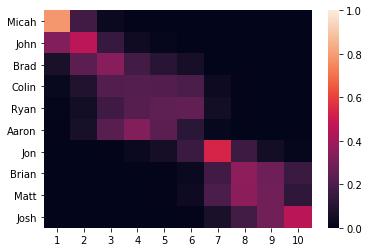

In [99]:
sns.heatmap(probs_sorted, annot=False, vmin=0, vmax=1)

In [100]:
formatted = (probs[["1", "2", "3"]]*100).sort_values("1", ascending=False).round(0).astype(int).astype(str)+'%'
formatted.to_csv("probabilities.txt", sep=" ", header=False)

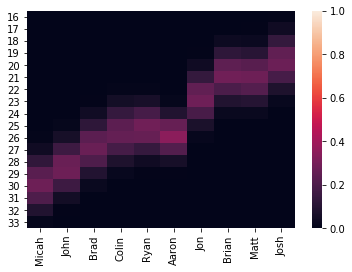

In [101]:
# score distribution for individual players
dist_df = []
for person in persons:
    dist_df.append(pd.DataFrame(df_wins.groupby(person).size() / n_sims))

dist_df = pd.concat(dist_df, axis=1).fillna(0)
dist_df.columns = persons
#dist_df.style.format("{:.1%}")
sns.heatmap(dist_df[probs_sorted.index], annot=False, vmin=0, vmax=1)

In [102]:
# union team data to compute wins
a = df[["person1", "team1", "prob1", "week"]].rename(columns={"person1":"person", "team1":"team", "prob1":"prob"})
b = df[["person2", "team2", "prob2", "week"]].rename(columns={"person2":"person", "team2":"team", "prob2":"prob"})
df_union = pd.concat([a, b], axis=0, ignore_index=True)
df_union["win"] = (df_union["prob"] == 1).astype(int)
totals = df_union.groupby(["person", "team"]).sum().reset_index()

In [103]:
# text for Notes app
text = ''
for person in persons:
    team_scores = totals[totals.person==person]
    score_text = "\n".join(" - " + team_scores.team + ": " + team_scores.win.astype(str))
    person_total = "TOTAL: " + str(team_scores.win.sum())
    person_max = "MAX: " + str(df_current.loc[person].max_possible)
    placement_prob = "1st 2nd 3rd: " + " ".join((probs[["1", "2", "3"]].loc[person]*100).round(0).astype(int).astype(str) + "%")
    parts = [person, score_text, person_total, person_max, placement_prob, "\n"]
    text += "\n".join(parts)
    
open("report.txt", "w").write(text)

960

In [104]:
# games left for given week
df_union[(df_union.prob!=0) & (df_union.prob!=1) & (df_union.week==14)]
#df_union[(df_union.week==10)]

,person,team,prob,week,win


In [105]:
df_union[(df_union.person=='Micah') & (df_union.week>13)].sort_values('prob')

,person,team,prob,week,win
58,Micah,Denver,0.00,14,0
302,Micah,Denver,0.38,17,0
10,Micah,Tennessee,0.51,15,0
31,Micah,Denver,0.60,16,0
295,Micah,Tennessee,0.62,17,0
15,Micah,New Orleans,0.69,15,0
258,Micah,Denver,0.69,15,0
272,Micah,Tennessee,0.72,16,0
285,Micah,New Orleans,0.75,16,0
289,Micah,New Orleans,0.83,17,0


In [106]:
# scores by week
finished = (df_union.prob==0) | (df_union.prob==1)
df_totals = df_union[finished].rename(index=str, columns={'week':'Wk'}).groupby(['Wk', 'person']).sum().reset_index()
df_cumul = df_totals.pivot(index='Wk', columns='person', values='prob')[persons].cumsum()
df_cumul.columns = [c[0] for c in df_cumul.columns]
df_cumul.round().astype(int)

,A,B,B,C,J,J,J,M,M,R
Wk,,,,,,,,,,
1,1,2,2,0,2,2,3,0,1,2
2,3,4,4,1,3,3,3,2,4,3
3,4,6,5,2,6,4,4,2,6,6
4,6,7,6,3,8,7,4,4,8,7
5,7,7,7,5,9,8,6,5,9,10
6,8,10,8,6,11,10,9,7,9,10
7,9,10,9,9,12,10,11,9,11,12
8,11,11,10,11,13,12,12,9,12,14
9,14,12,11,12,13,12,13,11,14,16


In [107]:
df_cumul_out = df_cumul.round().astype(int).astype(str).reset_index()
df_titles = pd.DataFrame(np.expand_dims(df_cumul_out.columns.values, 0), columns=df_cumul_out.columns)
np.savetxt('scores_by_week.txt', pd.concat([df_titles, df_cumul_out]), fmt='%2s')

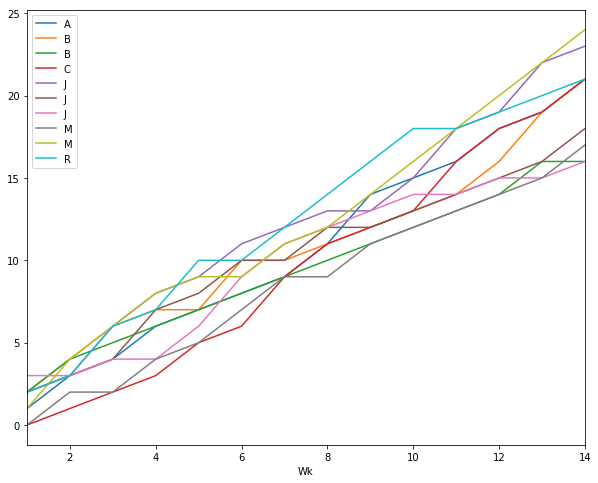

In [108]:
df_cumul.plot(figsize=(10,8))